# Anlizando correlaciones entre activos, y realizando indices sinteticos, como forma de exposicion permamente a mercado

Vamos a cargar las librerias necesarias.

In [6]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = 20,12
plt.style.use('ggplot')

import matplotlib.mlab as mlab
import math
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Cargamos los archivos de los futuros, en este lab en el github se incluiran una version reducida de los mismos en formato pickle

In [7]:
vixcash = pd.read_csv('/home/py/lab1/lab1/datasets/Futures/Cash/$VIX.csv',parse_dates=['Date'],index_col=['Date'])
spcash = pd.read_csv('/home/py/lab1/lab1/datasets/Futures/Cash/$SP.csv',parse_dates=['Date'],index_col=['Date'])
bondcash = pd.read_csv('/home/py/lab1/lab1/datasets/Futures/Cash/$TYX.csv',parse_dates=['Date'],index_col=['Date'])
djcash = pd.read_csv('/home/py/lab1/lab1/datasets/Futures/Cash/$DJ.csv',parse_dates=['Date'],index_col=['Date'])
nqcash = pd.read_csv('/home/py/lab1/lab1/datasets/Futures/Cash/$NQ.csv',parse_dates=['Date'],index_col=['Date'])
usdcash = pd.read_csv('/home/py/lab1/lab1/datasets/Futures/Cash/$DX.csv',parse_dates=['Date'],index_col=['Date'])
gldcash = pd.read_csv('/home/py/lab1/lab1/datasets/Futures/Cash/$GC.csv',parse_dates=['Date'],index_col=['Date'])
alcash = pd.read_csv('/home/py/lab1/lab1/datasets/Futures/Cash/$AL.csv',parse_dates=['Date'],index_col=['Date'])
caccash = pd.read_csv('/home/py/lab1/lab1/datasets/Futures/Cash/$CA.csv',parse_dates=['Date'],index_col=['Date'])
dxcash = pd.read_csv('/home/py/lab1/lab1/datasets/Futures/Cash/$DA.csv',parse_dates=['Date'],index_col=['Date'])
plcash = pd.read_csv('/home/py/lab1/lab1/datasets/Futures/Cash/$PL.csv',parse_dates=['Date'],index_col=['Date'])
lhcash = pd.read_csv('/home/py/lab1/lab1/datasets/Futures/Cash/$LH.csv',parse_dates=['Date'],index_col=['Date'])


Creamos un nuevo dataframe, para anadir los datos necesarios para su posterior tratamiento. En este caso estamos cogiendo el dato del cierre de dia, de los indices en cash de:  

  * VIX  

  * SP 500  

  * BONOS 30 USA  

  * DOW JONES  

  * NASDAQ  

  * ORO  

  * ALUMINIO  

  * CAC 40  

  * DAX  
  * PLATINO  
  * LEAN HOGS  
  * DOLAR INDEX  

In [8]:
df = pd.DataFrame()
df = df.reindex_like(vixcash)
df['VIX'] = vixcash.Close
df['SPX'] = spcash.Close
df['30Y'] = bondcash.Close
df['DJ'] = djcash.Close
df['NQ'] = nqcash.Close
df['GC'] = gldcash.Close
df['DX'] = usdcash.Close
df['AL'] = alcash.Close
df['CAC'] = caccash.Close
df['DX'] = dxcash.Close
df['PL'] = plcash.Close
df['LH'] = lhcash.Close
df['US'] = usdcash.Close
df=df.drop(['Ticker','Open','High','Low','Close','Volume','Open Interest'],axis=1)

Calculamos correlaciones del dataframe. Al tener todos el cierre en el mismo timeframe, se obtendran unas correlaciones entre series.

In [9]:
correlacion = df.corr(method = 'kendall')
correlacion_mean = correlacion.mean() 
print(correlacion_mean)

VIX   -0.000137
SPX    0.409595
30Y   -0.230538
DJ     0.412120
NQ     0.403612
GC     0.241680
DX     0.410683
AL     0.237212
CAC    0.338756
PL     0.302840
LH     0.157359
US    -0.025664
dtype: float64


# Ploteamos un mapa de calor, para visualizar las conclusiones

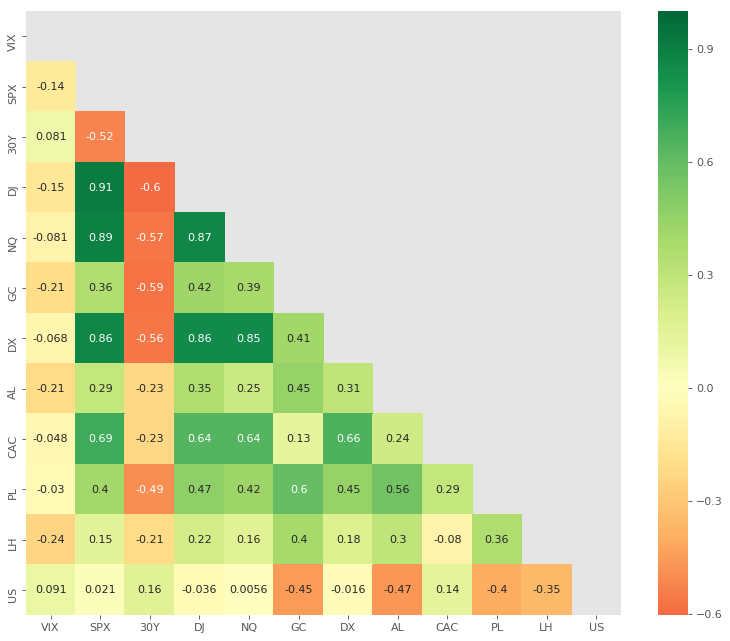

In [10]:
mask = np.zeros_like(correlacion, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


plt.figure(figsize=(12,10),dpi=80)
sns.heatmap(correlacion,mask=mask,
            cmap='RdYlGn',center=0, annot=True)

Llegados a este punto, es donde nuestra mente, mediante nuestros sesgos intentara hacernos justificar la correlacion inversa entre el aluminio y el VIX, o similares. Yo prefiero abstenerme de este tipo de cuestiones,aunque se que funcionan, pero de ello se requiere un analisis muchisimo mas detallado, que este lab introductorio.Las correlaciones historicamente han funcionado, pero actualmente, los mercados estan protegidos por los bancos centrales, y su comportamiento a cambiado.



# Adaptamos las funciones del webinario 3 de @tiotino a nuestras necesidades

Mi intencion con los primeros notebooks, es que no se complicaran en exceso los notebooks, pero creo que ya es el momento de tocar un poco de codigo mas elegante, extraido del webinario 3 de value at risk, con Valentin Morata, y adaptarlo a nuestras necesidades.

In [11]:
def calculate_aggregate(values, graph=True,box=True):
    t_test=(values.mean()/(values.std()/math.sqrt(len(values))))
    agg_measures = {
        'avg': np.round(values.mean(),3),
        'std': values.std(),
        'var': values.var(),
        'val': values.quantile(.95)/values.quantile(.05),
        '05p': values.quantile(.05),
        '50p': values.quantile(.50),
        '95p': values.quantile(.95),
        '01p': values.quantile(.01),
        'skw': values.skew(),
        'kur': values.kurtosis(),
        'T-test': t_test
    }
    
    for n in sorted(agg_measures.keys()):
        koko=" el valor de {} es : {:2.5} ".format(n,agg_measures[n])
        print (koko)
    
    print('Maximo Retorno 1D :'+str(values.pct_change().max()*100) + '%')
    print('El Dia :'+str(values.pct_change().idxmax()))
    print('Minimo Retorno 1D :'+str(values.pct_change().min()*100) + '%')
    print('El Dia :'+str(values.pct_change().idxmin()))
    print('Maximo Historico:'+str(values.max()))
    print('El Dia :'+str(values.idxmax()))
    print('Minimo Historico :'+str(values.min()))
    print('El Dia :'+str(values.idxmin()))
    
   


In [12]:
def correlations(df1,df2, graph=True,info=True,period=30):
    if info==True :
        print('-------------------')
        print('Estadisticas de df1')
        print('-------------------')
        calculate_aggregate(df1)
        print('-------------------')
        print('Estadisticas de df2')
        print('-------------------')
        calculate_aggregate(df2)
        print('-------------------')
        corrs = df1.rolling(period).corr(df2.rolling(period))
        desde = corrs.index > '2000-01-01'
        corrs = corrs[desde]
        corrs.plot()


    return corrs ;

-------------------
Estadisticas de df1
-------------------
 el valor de 01p es : 7.2 
 el valor de 05p es : 9.71 
 el valor de 50p es : 94.32 
 el valor de 95p es : 1920.0 
 el valor de T-test es : 102.62 
 el valor de avg es : 424.19 
 el valor de kur es : 2.4458 
 el valor de skw es : 1.775 
 el valor de std es : 640.64 
 el valor de val es : 197.74 
 el valor de var es : 4.1042e+05 
Maximo Retorno 1D :16.609589041095884%
El Dia :1933-03-15 00:00:00
Minimo Retorno 1D :-20.466928883377122%
El Dia :1987-10-19 00:00:00
Maximo Historico:2943.03003
El Dia :2019-04-29 00:00:00
Minimo Historico :4.4
El Dia :1932-06-01 00:00:00
-------------------
Estadisticas de df2
-------------------
 el valor de 01p es : 132.71 
 el valor de 05p es : 166.46 
 el valor de 50p es : 1484.5 
 el valor de 95p es : 5916.0 
 el valor de T-test es : 98.274 
 el valor de avg es : 1888.9 
 el valor de kur es : 1.2329 
 el valor de skw es : 1.3269 
 el valor de std es : 1768.2 
 el valor de val es : 35.54 
 el val

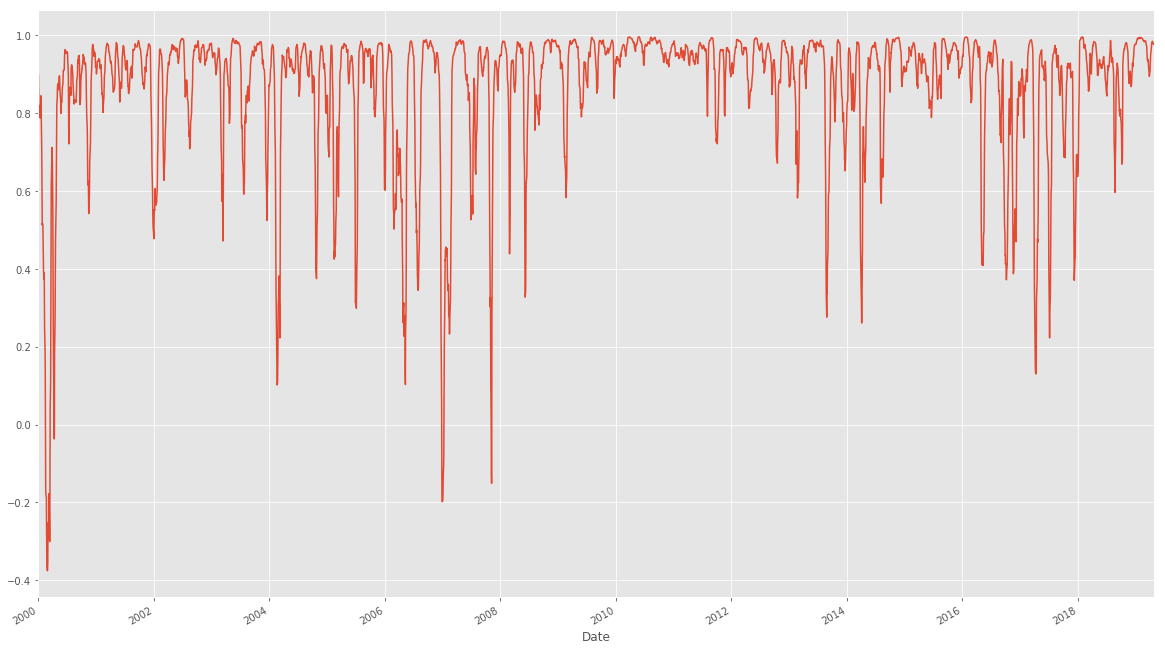

In [13]:
corrs = correlations(spcash.Close,nqcash.Close)

# Creacion de Indices Sinteticos

Crearemos unos indices sinteticos. Para quien no este familiarizado con el concepto, definimos un indice sintetico cona una combinacion de instrumentos financieros utilizada para simular rendimientos pasados y poder comprobar la validez de una hipotesis, o para generar un indice de precios ponderado con los activos que necesitemos moritorizar, o para cada una de las utilidades que se ocurran.  
  
Vamos a generar unas carteras, y vamos a seleccionar criterios (al azar), obivamente no se busca rentabilidad, sino prueba de concepto. Todo el contenido aqui publicado esta ideado dentro del ambito divulgativo,no para proporcionar sistemas rentables

In [14]:
cartera6 = 0.15* usdcash.Close.pct_change() + 0.75 * bondcash.Close.pct_change()
cartera5 = 0.15*dxcash.Close.pct_change() + 0.10*caccash.Close.pct_change() + 0.25 * djcash.Close.pct_change() + 0.25* nqcash.Close.pct_change() + 0.25 * spcash.Close.pct_change()
cartera4 = 0.75* spcash.Close.pct_change() + 0.25 * bondcash.Close.pct_change()
cartera3 = -1* spcash.Close.pct_change()
cartera2 = 0.30* nqcash.Close.pct_change() + 0.30 * djcash.Close.pct_change() + 0.40 * spcash.Close.pct_change()
cartera1 = 0.25* spcash.Close.pct_change() + 0.75 * bondcash.Close.pct_change()


In [15]:
cartera = pd.DataFrame()
trades = pd.DataFrame()
cartera['1'] = (cartera1)*100
cartera['2'] = (cartera2)*100
cartera['3'] = (cartera3)*100
cartera['4'] = (cartera4)*100
cartera['5'] = (cartera5)*100
cartera['6'] = (cartera6)*100

Vamos a filtrar por una fecha, sumamos todos los retornos de los indicies y los ploteamos de manera rapida.

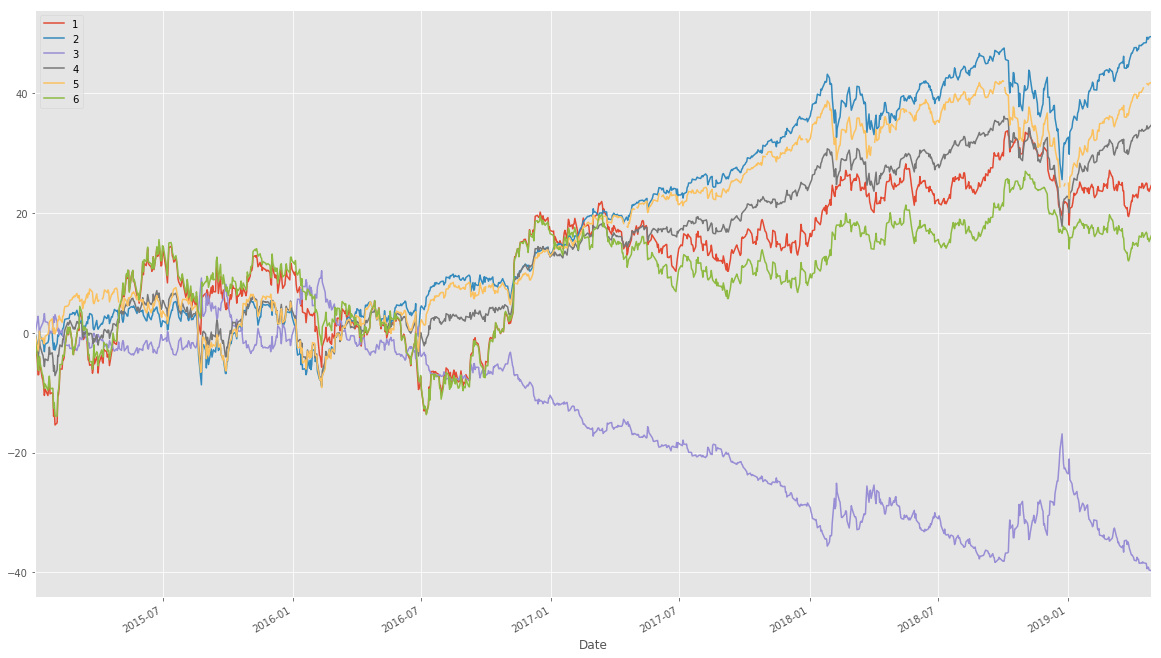

In [16]:
sett = cartera.index > '2015-01-01'
cartera = cartera[sett]
cartera = cartera.cumsum()
cartera.plot()
plt.show()

Como conclusion, hay que ver, que el buy and hold en renta variable es una estrategia volatil y aburrida pero rentable. 
  
  
La linea que llega hasta el -40% es una posicion netamente corta en renta variable. 

[The Python Lab](https://www.thepythonlab.com) 

[Python Para Trading](https://t.me/pythontrading) 